In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, 'code/')

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchsummaryX import summary

from tqdm import tqdm_notebook as tqdm

from mac import MACNetwork
from utils import load_vocab
from datasets import ClevrDataset, collate_fn, QOnlyDataset, qonly_collate_fn

In [4]:
from config import cfg_from_file, __C, cfg

cfg_from_file('cfg/clevr_train_mac.yml')
__C.CUDA = False
__C.GPU_ID = '-1'
vocab = load_vocab(cfg)
# cfg.TRAIN.RECV_OBJECTS = False

code/config.py:83: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [6]:
model = MACNetwork(cfg=cfg, max_step=4, vocab=vocab)
# model.load_state_dict(torch.load('/Users/sebamenabar/Documents/concept_mac_transform.pth', map_location='cpu')['model'])

In [8]:
def forward_q(model, question, question_len):
    embed = model.input_unit.encoder_embed(question)
    embed = model.input_unit.embedding_dropout(embed)
    embed = nn.utils.rnn.pack_padded_sequence(embed, question_len, batch_first=True)

    contextual_words, (question_embedding, _) = model.input_unit.encoder(embed)
    if model.input_unit.bidirectional:
        question_embedding = torch.cat([question_embedding[0], question_embedding[1]], -1)
    question_embedding = model.input_unit.question_dropout(question_embedding)

    contextual_words, _ = nn.utils.rnn.pad_packed_sequence(contextual_words, batch_first=True)
    
    return question_embedding, contextual_words

def get_category_attention(model, cws):
    return model.mac.control.concept_memory.get_category_attention(cws.contiguous().view(-1, 512))

def get_both(model, question, question_len):
    _, cws = forward_q(model, question, question_len)
    cattention = get_category_attention(model, cws)
        
    return cws, cattention.view(cws.size(0), cws.size(1), -1)

In [9]:
ds = QOnlyDataset(
    data_dir='/Users/sebamenabar/Documents/datasets/CLEVR/data',
    # img_dir='/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/images/',
    # scenes_json='/Users/sebamenabar/Documents/TAIA/individual/sm/data/clevr/train/scenes.json',
    # raw_image=True,
    split='val',
)

In [26]:
loader = DataLoader(dataset=ds, batch_size=10, shuffle=True,
                                       num_workers=2, drop_last=False, collate_fn=qonly_collate_fn)

In [15]:
b = next(iter(loader))

In [16]:
def idxs_to_q(questions, vocab):
    return [
        ' '.join([
            vocab[idx.item()] for idx in question if idx.item() !=0
        ]) for question in questions
    ]

In [102]:
vocab

{'question_token_to_idx': {'Are': 1,
  'there': 2,
  'more': 3,
  'big': 4,
  'green': 5,
  'things': 6,
  'than': 7,
  'large': 8,
  'purple': 9,
  'shiny': 10,
  'cubes': 11,
  '?': 12,
  'How': 13,
  'many': 14,
  'other': 15,
  'are': 16,
  'of': 17,
  'the': 18,
  'same': 19,
  'shape': 20,
  'as': 21,
  'tiny': 22,
  'cyan': 23,
  'matte': 24,
  'object': 25,
  'Is': 26,
  'color': 27,
  'sphere': 28,
  'cube': 29,
  'What': 30,
  'material': 31,
  'is': 32,
  'that': 33,
  'right': 34,
  'brown': 35,
  'cylinder': 36,
  'and': 37,
  'left': 38,
  'gray': 39,
  'on': 40,
  'side': 41,
  'small': 42,
  'rubber': 43,
  'behind': 44,
  'thing': 45,
  'to': 46,
  'metallic': 47,
  'The': 48,
  'what': 49,
  'size': 50,
  'any': 51,
  'have': 52,
  'block': 53,
  'blue': 54,
  'yellow': 55,
  'There': 56,
  'a': 57,
  ';': 58,
  'it': 59,
  'ball': 60,
  'its': 61,
  'in': 62,
  'front': 63,
  'does': 64,
  'number': 65,
  'red': 66,
  'spheres': 67,
  'made': 68,
  'metal': 69,
  'cy

In [27]:
res = {
    idx: {
        'cws': torch.FloatTensor(0, 512),
        'category': torch.FloatTensor(0, 4),
    } for idx in vocab['question_idx_to_token'].keys()
}

model.eval()
for i, batch in tqdm(enumerate(loader), total=len(loader)):
    with torch.no_grad():
        contextual_words, cattention = get_both(model, b['question'], b['question_length'])
        for idx, cw, cat in zip(
            b['question'].contiguous().view(-1),
            contextual_words.contiguous().view(-1, 512),
            cattention.contiguous().view(-1, 4),
        ):
            res[idx.item()]['cws'] = torch.cat((res[idx.item()]['cws'], cw.unsqueeze(0)))
            res[idx.item()]['category'] = torch.cat((res[idx.item()]['category'], cat.unsqueeze(0)))
        
    if i >= 100:
        break

In [19]:
res

{1: {'cws': tensor([[ 0.1230,  0.0285, -0.0388,  ..., -0.6942, -0.1201, -0.0238],
          [ 0.1230,  0.0285, -0.0388,  ...,  0.3321,  0.0183,  0.0534],
          [ 0.1230,  0.0285, -0.0388,  ...,  0.1650, -0.1521,  0.0152],
          ...,
          [ 0.1230,  0.0285, -0.0388,  ..., -0.6942, -0.1201, -0.0238],
          [ 0.1230,  0.0285, -0.0388,  ...,  0.3321,  0.0183,  0.0534],
          [ 0.1230,  0.0285, -0.0388,  ...,  0.1650, -0.1521,  0.0152]]),
  'category': tensor([[9.9041e-01, 9.5735e-03, 1.5350e-05, 8.3346e-12],
          [9.9041e-01, 9.5735e-03, 1.5350e-05, 8.3346e-12],
          [9.9041e-01, 9.5735e-03, 1.5350e-05, 8.3346e-12],
          [9.9041e-01, 9.5735e-03, 1.5350e-05, 8.3346e-12],
          [9.9041e-01, 9.5735e-03, 1.5350e-05, 8.3346e-12],
          [9.9041e-01, 9.5735e-03, 1.5350e-05, 8.3346e-12],
          [9.9041e-01, 9.5735e-03, 1.5350e-05, 8.3346e-12],
          [9.9041e-01, 9.5735e-03, 1.5350e-05, 8.3346e-12],
          [9.9041e-01, 9.5735e-03, 1.5350e-05, 8.

In [29]:
colors = ['gray', 'red', 'blue', 'green', 'brown', 'purple', 'cyan', 'yellow']
sizes = ['large', 'small']
shapes = ['cube', 'sphere', 'cylinder']
material = ['rubber', 'metal']

atts_dict = dict(colors=colors, sizes=sizes, shapes=shapes, material=material)
all_atts = [*colors, *sizes, *shapes, *material]

In [30]:
all_tensors = torch.cat([res[vocab['question_token_to_idx'][att]]['category'] for att in all_atts])

In [31]:
all_tensors.size()

torch.Size([3434, 4])

In [48]:
 import numpy as np
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(all_tensors[:, :256].numpy())

In [33]:
import matplotlib.pyplot as plt

%matplotlib notebook

from matplotlib.cm import get_cmap

get_cmap('tab20')

In [35]:
res[vocab['question_token_to_idx']['blue']]['category']

tensor([], size=(0, 4))

In [34]:
for color in colors:
    print(color, res[vocab['question_token_to_idx'][color]]['category'].mean(dim=0))

gray tensor([1.0000e+00, 4.0904e-15, 1.7037e-16, 4.1710e-19])
red tensor([0.4911, 0.0062, 0.0055, 0.4972])
blue tensor([nan, nan, nan, nan])
green tensor([9.9935e-01, 4.0261e-12, 4.8673e-04, 1.6717e-04])
brown tensor([5.0882e-01, 4.9104e-01, 1.2356e-04, 1.6288e-05])
purple tensor([6.6612e-01, 3.2894e-01, 2.4538e-09, 4.9404e-03])
cyan tensor([9.9897e-10, 2.3228e-06, 1.8000e-11, 1.0000e+00])
yellow tensor([9.9992e-01, 7.8737e-05, 4.7659e-06, 2.2501e-13])


In [36]:
for att in sizes:
    print(att, res[vocab['question_token_to_idx'][att]]['category'].mean(dim=0))

large tensor([9.5119e-01, 5.5707e-10, 4.8805e-02, 7.8465e-06])
small tensor([5.0000e-01, 1.2388e-09, 4.5389e-11, 5.0000e-01])


In [37]:
for att in shapes:
    print(att, res[vocab['question_token_to_idx'][att]]['category'].mean(dim=0))

cube tensor([2.3622e-01, 8.9845e-02, 6.7354e-01, 3.8688e-04])
sphere tensor([1.9055e-02, 1.0533e-04, 1.3661e-01, 8.4423e-01])
cylinder tensor([9.9848e-01, 8.2594e-09, 1.5216e-03, 1.6976e-07])


In [38]:
for att in material:
    print(att, res[vocab['question_token_to_idx'][att]]['category'].mean(dim=0))

rubber tensor([0.2594, 0.0074, 0.2430, 0.4903])
metal tensor([4.1865e-01, 1.4539e-09, 4.2320e-11, 5.8135e-01])


In [39]:
res[vocab['question_token_to_idx']['brown']]['category'].mean(dim=0)

tensor([5.0882e-01, 4.9104e-01, 1.2356e-04, 1.6288e-05])

In [40]:
res[vocab['question_token_to_idx']['red']]['category'].mean(dim=0)

tensor([0.4911, 0.0062, 0.0055, 0.4972])

In [42]:
res[vocab['question_token_to_idx']['purple']]['category'].mean(dim=0)

tensor([6.6612e-01, 3.2894e-01, 2.4538e-09, 4.9404e-03])

In [43]:
res[vocab['question_token_to_idx']['cyan']]['category'].mean(dim=0)

tensor([9.9897e-10, 2.3228e-06, 1.8000e-11, 1.0000e+00])

In [44]:
res[vocab['question_token_to_idx']['blue']]['category'].mean(dim=0)

tensor([nan, nan, nan, nan])

<IPython.core.display.Javascript object>


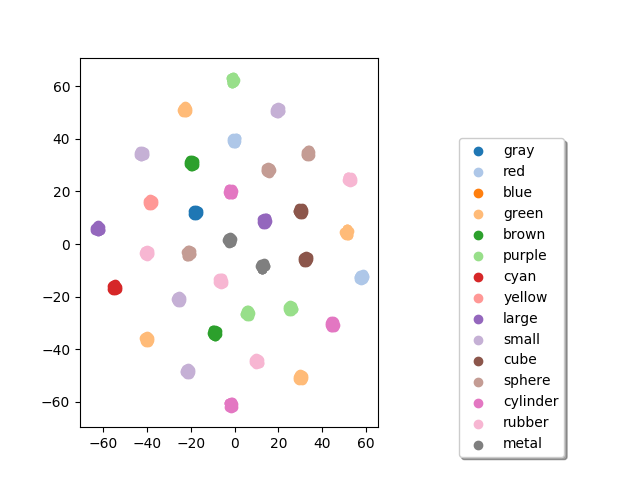

gray 101
red 202
blue 0
green 404
brown 202
purple 303
cyan 101
yellow 101
large 202
small 404
cube 202
sphere 303
cylinder 303
rubber 404
metal 202


In [49]:
cmap = get_cmap('tab20')

i = 0
j = 0

fig = plt.figure()
ax = plt.subplot(111)

for categories, attributes in atts_dict.items():
    
    for value in attributes:
        current = res[vocab['question_token_to_idx'][value]]['category'].size(0)
        print(value, current)

    
        ax.scatter(transformed[i:i + current, 0], transformed[i:i + current, 1], label=value, c=[cmap.colors[j]])
        
        # ax.scatter(x, y, label='$y = numbers')
        i = i + current
        j += 1
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.show()

# plt.legend()